In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install rouge

In [3]:
! pip install datasets
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from rouge import Rouge
from datasets import load_dataset
import matplotlib.pyplot as plt

In [11]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [6]:
def process_data_to_model_inputs(batch):
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=max_article_length)
    outputs = tokenizer(batch["highlights"], padding="max_length", truncation=True, max_length=max_summary_length)

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["labels"] = outputs.input_ids

    return batch

In [7]:
dataset = load_dataset('cnn_dailymail', '3.0.0')

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [19]:
test_data = dataset['test']
data_df = pd.DataFrame(test_data)

In [20]:
data_df['article_length'] = data_df['article'].apply(lambda x: len(x))

In [22]:
import math
data_df['summary_length'] = data_df['article'].apply(lambda x: math.ceil(len(x)/10))

In [25]:
model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/t5_transfer_learning/model")

In [34]:
def get_summary(row):

    max_input_length = row['article_length']
    max_summary_length = row['summary_length']
    input_text = row['article']
    input_ids = tokenizer.encode(input_text, truncation=True, max_length=max_input_length, return_tensors="pt")

    summary_ids = model.generate(input_ids, max_length=max_summary_length)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [35]:
data_df['summary'] = data_df.apply(lambda row: get_summary(row), axis=1)

In [36]:
rouge = Rouge()

data_df['rouge_scores'] = data_df.apply(lambda row: rouge.get_scores(row['summary'], row['highlights']), axis=1)

In [37]:
data_df.to_csv('/content/drive/MyDrive/t5_transfer_learning/t5_transfer_learning.csv.zip', index=False, compression='zip')

In [38]:
rouge_scores = data_df['rouge_scores']

rouge_1 = {'r': 0, 'p': 0, 'f': 0}
rouge_2 = {'r': 0, 'p': 0, 'f': 0}
rouge_l = {'r': 0, 'p': 0, 'f': 0}

for scores in rouge_scores:
    rouge_1_scores = scores[0]['rouge-1']
    rouge_2_scores = scores[0]['rouge-2']
    rouge_l_scores = scores[0]['rouge-l']

    rouge_1['r'] += rouge_1_scores['r']
    rouge_1['p'] += rouge_1_scores['p']
    rouge_1['f'] += rouge_1_scores['f']

    rouge_2['r'] += rouge_2_scores['r']
    rouge_2['p'] += rouge_2_scores['p']
    rouge_2['f'] += rouge_2_scores['f']

    rouge_l['r'] += rouge_l_scores['r']
    rouge_l['p'] += rouge_l_scores['p']
    rouge_l['f'] += rouge_l_scores['f']

num_rows = len(rouge_scores)

rouge_1_avg = {'recall': rouge_1['r'] / num_rows, 'precision': rouge_1['p'] / num_rows, 'f1-score': rouge_1['f'] / num_rows}
rouge_2_avg = {'recall': rouge_2['r'] / num_rows, 'precision': rouge_2['p'] / num_rows, 'f1-score': rouge_2['f'] / num_rows}
rouge_l_avg = {'recall': rouge_l['r'] / num_rows, 'precision': rouge_l['p'] / num_rows, 'f1-score': rouge_l['f'] / num_rows}

average_scores = pd.DataFrame({'ROUGE-1': rouge_1_avg, 'ROUGE-2': rouge_2_avg, 'ROUGE-L': rouge_l_avg})

average_scores.to_csv('/content/drive/MyDrive/t5_transfer_learning/t5_transfer_learning_rouge.csv', index=True)

average_scores

,ROUGE-1,ROUGE-2,ROUGE-L
recall,0.308955,0.132015,0.292480
precision,0.452385,0.201771,0.428042
f1-score,0.359179,0.155194,0.339967


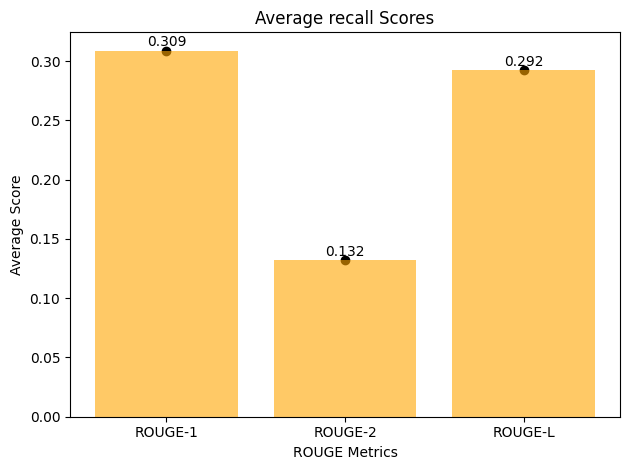

In [39]:
x_values = average_scores.columns
y_values = average_scores.loc['recall']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average recall Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

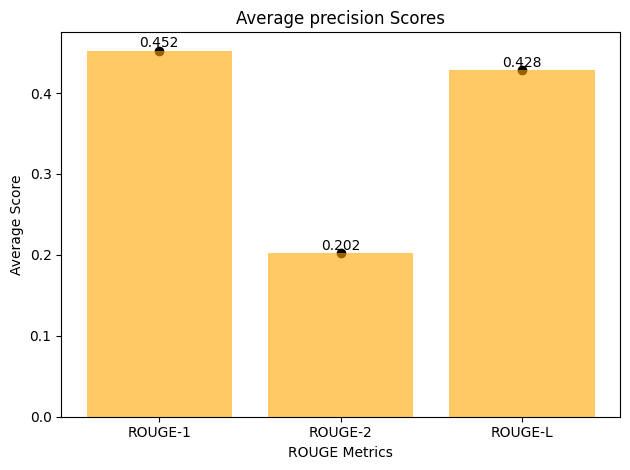

In [40]:
x_values = average_scores.columns
y_values = average_scores.loc['precision']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average precision Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

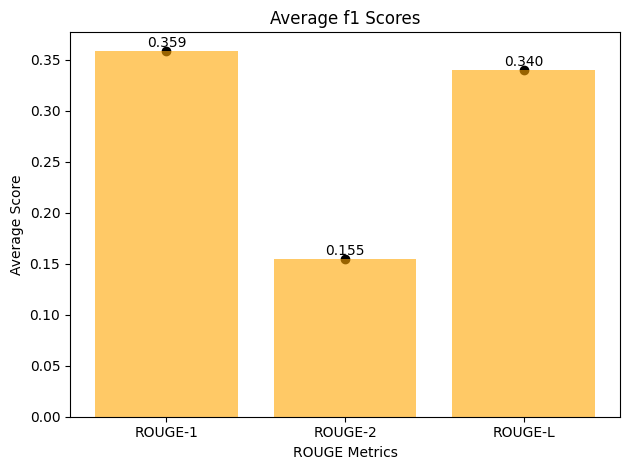

In [41]:
x_values = average_scores.columns
y_values = average_scores.loc['f1-score']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average f1 Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

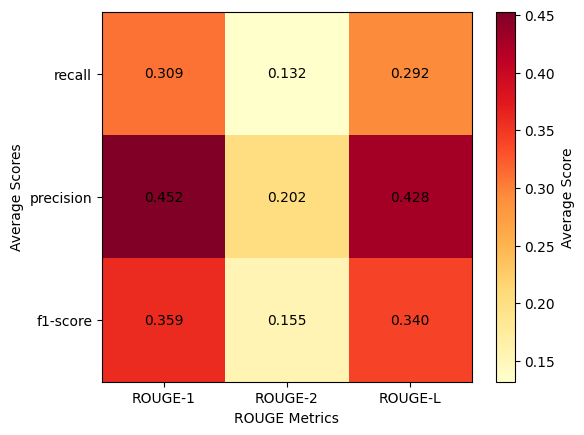

In [42]:
plt.imshow(average_scores, cmap='YlOrRd')

plt.xticks(range(len(average_scores.columns)), average_scores.columns)
plt.yticks(range(len(average_scores.index)), average_scores.index)
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average Scores')

for i in range(len(average_scores.index)):
    for j in range(len(average_scores.columns)):
        plt.text(j, i, f'{average_scores.iloc[i, j]:.3f}', ha='center', va='center', color='black')

plt.colorbar(label='Average Score')

plt.show()